# 드라이브 연동 및 기본 셋팅
```
지난번과 동일한 과정을 통해 구글 드라이브를 연동시켜 주세요.  
Runtime (런타임) > Change Runtime Type (런타임 유형 변경) > 하드웨어 가속기 GPU  
로 설정을 해줍시다.  

코랩의 세션은 90분간 상호작용이 없으면 종료됩니다.  
때문에 여러분들이 큰 데이터를 학습시키고자 할 경우,
F12 > Console 탭에 다음을 복사해 붙여넣은 후 엔터를 눌러주세요.

function ClickConnect() {var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); buttons.forEach(function(btn) { btn.click(); }); console.log("1분마다 자동 재연결"); document.querySelector("colab-toolbar-button#connect").click(); } setInterval(ClickConnect,1000*60);

```

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense ,GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from google.colab.patches import cv2_imshow

In [3]:
# 폴더가 없으면 폴더를 쉽게 생성하기 위한 함수

def make_dir(path):
  if not os.path.isdir(path):
    os.mkdir(path)

# 데이터 나누기
```
이번 실습에서 다룰 데이터셋은 Chess Dataset이지만,  
아쉽게도 이번 데이터셋은 예쁘게 나눠져있지 않습니다.  

그렇기 때문에 저희들은 좋은 모델을 선택하기 위해 임의로 데이터들을 나눠볼건데요,  
train과 valid 폴더를 각각 만들어 파일들을 일정량 옮겨줍시다.
이번 예제에서는 7:3의 비율로 각각 만들어줄게요.
```

In [4]:
root_path = "/content/gdrive/MyDrive/Colab Notebooks/컴퓨터비전/컴비_기말/"
train_path = root_path + "train"
valid_path = root_path + "valid"
test_path = root_path + "test"
data_path = root_path + "all_data"

make_dir(train_path)
make_dir(valid_path)
make_dir(test_path)

class_list = os.listdir(data_path)
class_list.sort()

for class_name in class_list:
  temp_path = train_path + "/" + class_name
  make_dir(temp_path)
 
for class_name in class_list:
  temp_path = valid_path + "/" + class_name
  make_dir(temp_path)
for class_name in class_list:
  temp_path = test_path + "/" + class_name
  make_dir(temp_path)


In [ ]:
# import shutil

# for class_name in class_list:
#   image_list = os.listdir(data_path + '/' + class_name)
#   image_num = len(image_list)
#   print(class_name + " folder has " + str(image_num) + " images.")
  
#   train_index = int(image_num * 0.6)
#   vaild_index = int(image_num * 0.2)
#   for image in image_list[:train_index]:
#     shutil.copy(data_path + "/" + class_name + "/" + image,                ##train
#                 train_path + "/" + class_name + "/" + image)
    
#   for image in image_list[train_index:train_index+vaild_index]:            ##vaild
#     shutil.copy(data_path + "/" + class_name + "/" + image,
#                 valid_path + "/" + class_name + "/" + image)
    
#   for image in image_list[train_index+vaild_index:]:            ##test
#     shutil.copy(data_path + "/" + class_name + "/" + image,
#                 test_path + "/" + class_name + "/" + image)
        
    
#   print("Image moved.")


# 이미지의 개수 파악
```
Image Data Generator를 사용하기 위해서는  
전체 데이터를 얼마만큼의 batch로 받아들일지에 대한 계산을 반드시 해야합니다.

그렇기 때문에 데이터에 대한 정보 파악이 무엇보다 중요합니다.  
지난시간에도 말씀드렸듯, 체스 데이터셋에는 .gif, .php과 같은 많은 확장자들이 섞여 있는데요,  
이 중에서 이미지 파일의 개수만 얻어봅시다.
```

In [5]:
for class_name in class_list:
  count = 0
  for image in os.listdir(train_path + '/' + class_name):
    if image[-3:] == "jpg" or image[-3:] == "png" or image[-4:] == "JPEG" or image[-4:] == "jpeg":
      count += 1
  print("Train " + class_name + " : " + str(count))

  count = 0
  for image in os.listdir(valid_path + '/' + class_name):
    if image[-3:] == "jpg" or image[-3:] == "png" or image[-4:] == "JPEG" or image[-4:] == "jpeg":
      count += 1
  print("Valid " + class_name + " : " + str(count) + '\n')

  count = 0
  for image in os.listdir(test_path + '/' + class_name):
    if image[-3:] == "jpg" or image[-3:] == "png" or image[-4:] == "JPEG" or image[-4:] == "jpeg":
      count += 1
  print("Test " + class_name + " : " + str(count) + '\n')

Train just_face : 523
Valid just_face : 174

Test just_face : 176

Train with_mask : 374
Valid with_mask : 124

Test with_mask : 126



# Image Data Generator 사용하기
```
Image Data Generator는 크게 두부분으로 이루어져 있습니다.
ImageDataGenerator로 선언을 해주고, 저희가 적용하고자 하는 데이터 증강 기법들을 적어주는 부분,  
실제 폴더에서 데이터들을 batch만큼 불러오도록 설정하는 부분입니다.

먼저 데이터 증강이 어떻게 되는지 확인해 본 뒤, 직접 학습, 검증, 테스트 셋에 적용해봅시다.
```

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.4,
    height_shift_range=0.3,
    shear_range=0.35,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(512, 512),
    batch_size = 64,
    class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(512, 512),
    batch_size = 64,
    
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(512,512),
    batch_size = 64,
    shuffle=False,
    class_mode='categorical')
print(train_generator.n , train_generator.batch_size)

Found 897 images belonging to 2 classes.
Found 298 images belonging to 2 classes.
Found 302 images belonging to 2 classes.
897 64


기본 모델

In [7]:
from tensorflow.keras.layers import BatchNormalization, Dropout

def vanilla_model():
  input = Input(shape=(512, 512, 3))
  conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  batch1 = BatchNormalization()(pool1)

  conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  batch2 = BatchNormalization()(pool2)

  conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  batch3 = BatchNormalization()(pool3)

  conv4 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool3)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  batch4 = BatchNormalization()(pool4)

  flatten = Flatten()(pool4)
  dense1 = Dense(256, activation='relu')(flatten)
  drop1 = Dropout(0.3)(dense1)
  dense2 = Dense(64, activation='relu')(drop1)
  drop2 = Dropout(0.4)(dense2)
  output = Dense(2, activation='softmax')(drop2)

  model = Model(inputs=input, outputs=output)

  return model
model = vanilla_model()
opt = Adam(lr=0.001, decay=1e-6)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 64)        0     

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**pretrain**  Vgg16

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout
input = Input(shape=(512, 512, 3))
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(512, 512, 3))
#vgg_model.trainable=False
#vgg_model.summary()
print("\n","vgg=========================")
  # input = Input(shape=(512, 512, 3))
  # conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input)
  # pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  # batch1 = BatchNormalization()(pool1) 

model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

model.summary()
opt = Adam(lr=0.001, decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# ImageDataGenerator로 받은 이미지를 학습하는 부분
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = ModelCheckpoint('multiclass_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n  // train_generator.batch_size,  # 전체 train 이미지 사이즈를 정해둔 batch 사이즈로 나눠줍니다.
    validation_data = valid_generator,
    epochs = 50,
    callbacks=[early_stopping, checkpoint_callback]
)
fig, loss_acc = plt.subplots()
acc = loss_acc.twinx()

loss_acc.plot(history.history['loss'], 'y', label='train loss')
loss_acc.plot(history.history['val_loss'], 'r', label='val loss')
loss_acc.set_xlabel('epoch')
loss_acc.set_ylabel('loss')
loss_acc.legend(loc='upper left')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.plot(history.history['val_accuracy'], 'g', label='val acc')
acc.set_ylabel('accuracy')
acc.legend(loc='lower left')

plt.show()

scores = model.evaluate_generator(generator=test_generator)
print("Total Loss : ", scores[0], "\nTotal Accuracy : ", scores[1])


 vgg=========================
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 131072)            0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 256)               33554688  
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 128)               32896     
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 64)                8256      
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 2)                 130       
Total params: 48,310,658
Trainable params: 48,310,658
Non-trainable params: 0
_____________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 1.8601 - accuracy: 0.5593

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


resnet50

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout,GlobalAveragePooling2D

base_model = ResNet50(weights= "imagenet", include_top=False, input_shape= (512, 512, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(2, activation= 'sigmoid')(x)
model = Model(inputs = base_model.input, outputs = predictions)
opt = Adam(lr=0.001, decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


resnet50 + 모델 돌리기 (weight없이 !!)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


56/56 [==============================] - 124s 2s/step - loss: 0.7588 - accuracy: 0.7072 - val_loss: 0.6584 - val_accuracy: 0.5671

Epoch 00001: val_loss improved from inf to 0.65838, saving model to multiclass_weights.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
56/56 [==============================] - 107s 2s/step - loss: 0.6273 - accuracy: 0.7333 - val_loss: 1.4266 - val_accuracy: 0.4430

Epoch 00002: val_loss did not improve from 0.65838
Epoch 3/50
56/56 [==============================] - 108s 2s/step - loss: 0.6007 - accuracy: 0.7480 - val_loss: 134.2688 - val_accuracy: 0.5772

Epoch 00003: val_loss did not improve from 0.65838
Epoch 4/50
56/56 [==============================] - 107s 2s/step - loss: 0.5285 - accuracy: 0.7832 - val_loss: 16.8033 - val_accuracy: 0.5805

Epoch 00004: val_loss did not improve from 0.65838
Epoch 5/50
56/56 [==============================] - 107s 2s/step - loss: 0.5350 - accuracy: 0.7968 - val_loss: 7.5170 - val_accuracy: 0.5839

Epoch 00005: val_loss did not improve from 0.65838
Epoch 6/50
56/56 [==============================] - 106s 2s/step - loss: 0.4968 - accuracy: 0.7846 - val_loss: 0.7251 - val_accuracy: 0.5067

Epoch 00006: val_loss did not improve from 0.65838
Epoch 7/50
56/56 [==============

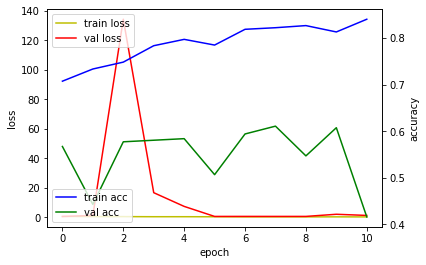

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Total Loss :  1.3799456357955933 
Total Accuracy :  0.4139072895050049


In [ ]:

# ImageDataGenerator로 받은 이미지를 학습하는 부분
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow
from keras.applications.resnet50 import ResNet50
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dropout,GlobalAveragePooling2D
with tensorflow.device('/gpu:0'):
  base_model = ResNet50(weights= None, include_top=False, input_shape= (512, 512, 3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.7)(x)
  predictions = Dense(2, activation= 'sigmoid')(x)
  model = Model(inputs = base_model.input, outputs = predictions)
  opt = Adam(lr=0.001, decay=1e-6)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  early_stopping = EarlyStopping(monitor='val_loss', patience=10)
  checkpoint_callback = ModelCheckpoint('multiclass_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

  history = model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.n  // train_generator.batch_size,  # 전체 train 이미지 사이즈를 정해둔 batch 사이즈로 나눠줍니다.
      validation_data = valid_generator,
      epochs = 50,
      callbacks=[early_stopping, checkpoint_callback]
  )
fig, loss_acc = plt.subplots()
acc = loss_acc.twinx()

loss_acc.plot(history.history['loss'], 'y', label='train loss')
loss_acc.plot(history.history['val_loss'], 'r', label='val loss')
loss_acc.set_xlabel('epoch')
loss_acc.set_ylabel('loss')
loss_acc.legend(loc='upper left')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.plot(history.history['val_accuracy'], 'g', label='val acc')
acc.set_ylabel('accuracy')
acc.legend(loc='lower left')

plt.show()

scores = model.evaluate_generator(generator=test_generator)
print("Total Loss : ", scores[0], "\nTotal Accuracy : ", scores[1])

모델 돌리는 부분

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.5618 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


14/14 [==============================] - 368s 26s/step - loss: 0.9770 - accuracy: 0.5618 - val_loss: 0.6738 - val_accuracy: 0.5839

Epoch 00001: val_loss improved from inf to 0.67375, saving model to multiclass_weights.h5
Epoch 2/50
14/14 [==============================] - 51s 4s/step - loss: 0.6693 - accuracy: 0.5858 - val_loss: 0.6700 - val_accuracy: 0.5738

Epoch 00002: val_loss improved from 0.67375 to 0.66999, saving model to multiclass_weights.h5
Epoch 3/50
14/14 [==============================] - 51s 4s/step - loss: 0.7003 - accuracy: 0.5210 - val_loss: 0.6809 - val_accuracy: 0.5839

Epoch 00003: val_loss did not improve from 0.66999
Epoch 4/50
14/14 [==============================] - 51s 4s/step - loss: 0.7022 - accuracy: 0.5522 - val_loss: 0.6896 - val_accuracy: 0.5839

Epoch 00004: val_loss did not improve from 0.66999
Epoch 5/50
14/14 [==============================] - 51s 4s/step - loss: 0.6769 - accuracy: 0.5834 - val_loss: 0.6781 - val_accuracy: 0.5839

Epoch 00005: val_l

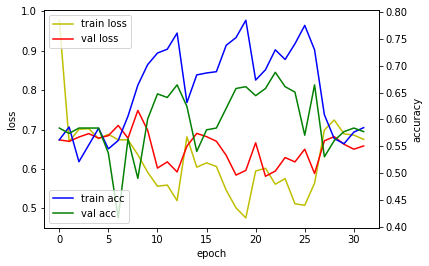


Epoch 00032: val_loss did not improve from 0.58147


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Total Loss :  0.7129427790641785 
Total Accuracy :  0.5894039869308472


In [8]:

# ImageDataGenerator로 받은 이미지를 학습하는 부분
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = ModelCheckpoint('multiclass_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n  // train_generator.batch_size,  # 전체 train 이미지 사이즈를 정해둔 batch 사이즈로 나눠줍니다.
    validation_data = valid_generator,
    epochs = 50,
    callbacks=[early_stopping, checkpoint_callback]
)
fig, loss_acc = plt.subplots()
acc = loss_acc.twinx()

loss_acc.plot(history.history['loss'], 'y', label='train loss')
loss_acc.plot(history.history['val_loss'], 'r', label='val loss')
loss_acc.set_xlabel('epoch')
loss_acc.set_ylabel('loss')
loss_acc.legend(loc='upper left')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.plot(history.history['val_accuracy'], 'g', label='val acc')
acc.set_ylabel('accuracy')
acc.legend(loc='lower left')

plt.show()

scores = model.evaluate_generator(generator=test_generator)
print("Total Loss : ", scores[0], "\nTotal Accuracy : ", scores[1])

epoch 64

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 0.8935 - accuracy: 0.5486 

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


14/14 [==============================] - 286s 18s/step - loss: 0.8935 - accuracy: 0.5486 - val_loss: 0.6880 - val_accuracy: 0.5671

Epoch 00001: val_loss improved from inf to 0.68804, saving model to multiclass_weights.h5
Epoch 2/50
14/14 [==============================] - 50s 4s/step - loss: 0.6624 - accuracy: 0.5822 - val_loss: 0.6667 - val_accuracy: 0.5872

Epoch 00002: val_loss improved from 0.68804 to 0.66674, saving model to multiclass_weights.h5
Epoch 3/50
14/14 [==============================] - 50s 4s/step - loss: 0.6024 - accuracy: 0.6543 - val_loss: 0.7006 - val_accuracy: 0.5940

Epoch 00003: val_loss did not improve from 0.66674
Epoch 4/50
14/14 [==============================] - 50s 4s/step - loss: 0.5950 - accuracy: 0.7227 - val_loss: 0.6638 - val_accuracy: 0.6342

Epoch 00004: val_loss improved from 0.66674 to 0.66377, saving model to multiclass_weights.h5
Epoch 5/50
14/14 [==============================] - 50s 4s/step - loss: 0.5570 - accuracy: 0.7095 - val_loss: 0.6892

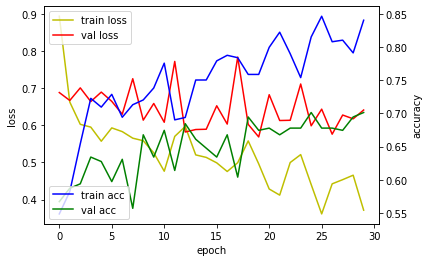

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Total Loss :  0.9368827939033508 
Total Accuracy :  0.6490066051483154


In [ ]:

# ImageDataGenerator로 받은 이미지를 학습하는 부분
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = ModelCheckpoint('multiclass_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 897  // 64,  # 전체 train 이미지 사이즈를 정해둔 batch 사이즈로 나눠줍니다.
    validation_data = valid_generator,
    epochs = 50,
    callbacks=[early_stopping, checkpoint_callback]
)
fig, loss_acc = plt.subplots()
acc = loss_acc.twinx()

loss_acc.plot(history.history['loss'], 'y', label='train loss')
loss_acc.plot(history.history['val_loss'], 'r', label='val loss')
loss_acc.set_xlabel('epoch')
loss_acc.set_ylabel('loss')
loss_acc.legend(loc='upper left')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.plot(history.history['val_accuracy'], 'g', label='val acc')
acc.set_ylabel('accuracy')
acc.legend(loc='lower left')

plt.show()

scores = model.evaluate_generator(generator=test_generator)
print("Total Loss : ", scores[0], "\nTotal Accuracy : ", scores[1])

epoch 16

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.5437

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


56/56 [==============================] - 684s 12s/step - loss: 0.6940 - accuracy: 0.5437 - val_loss: 0.6860 - val_accuracy: 0.5872

Epoch 00001: val_loss improved from inf to 0.68595, saving model to multiclass_weights.h5
Epoch 2/50
56/56 [==============================] - 66s 1s/step - loss: 0.6829 - accuracy: 0.5607 - val_loss: 0.6795 - val_accuracy: 0.5839

Epoch 00002: val_loss improved from 0.68595 to 0.67954, saving model to multiclass_weights.h5
Epoch 3/50
56/56 [==============================] - 66s 1s/step - loss: 0.6727 - accuracy: 0.5868 - val_loss: 0.6731 - val_accuracy: 0.5839

Epoch 00003: val_loss improved from 0.67954 to 0.67305, saving model to multiclass_weights.h5
Epoch 4/50
56/56 [==============================] - 66s 1s/step - loss: 0.6652 - accuracy: 0.5755 - val_loss: 0.6602 - val_accuracy: 0.5738

Epoch 00004: val_loss improved from 0.67305 to 0.66015, saving model to multiclass_weights.h5
Epoch 5/50
56/56 [==============================] - 65s 1s/step - loss: 0

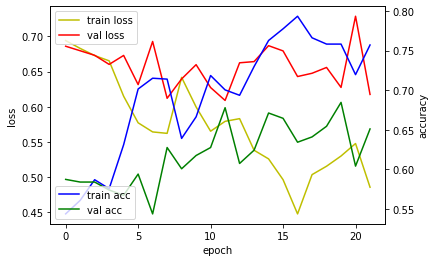

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Total Loss :  0.8125421404838562 
Total Accuracy :  0.6357616186141968


In [ ]:

# ImageDataGenerator로 받은 이미지를 학습하는 부분
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = ModelCheckpoint('multiclass_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 897  // 16,  # 전체 train 이미지 사이즈를 정해둔 batch 사이즈로 나눠줍니다.
    validation_data = valid_generator,
    epochs = 50,
    callbacks=[early_stopping, checkpoint_callback]
)
fig, loss_acc = plt.subplots()
acc = loss_acc.twinx()

loss_acc.plot(history.history['loss'], 'y', label='train loss')
loss_acc.plot(history.history['val_loss'], 'r', label='val loss')
loss_acc.set_xlabel('epoch')
loss_acc.set_ylabel('loss')
loss_acc.legend(loc='upper left')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.plot(history.history['val_accuracy'], 'g', label='val acc')
acc.set_ylabel('accuracy')
acc.legend(loc='lower left')

plt.show()

scores = model.evaluate_generator(generator=test_generator)
print("Total Loss : ", scores[0], "\nTotal Accuracy : ", scores[1])

epoch 4 - test valid train

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
224/224 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.5789

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


224/224 [==============================] - 82s 358ms/step - loss: 0.7090 - accuracy: 0.5789 - val_loss: 0.6862 - val_accuracy: 0.5839

Epoch 00001: val_loss improved from inf to 0.68619, saving model to multiclass_weights.h5
Epoch 2/50
224/224 [==============================] - 80s 356ms/step - loss: 0.6555 - accuracy: 0.6148 - val_loss: 0.8737 - val_accuracy: 0.5940

Epoch 00002: val_loss did not improve from 0.68619
Epoch 3/50
224/224 [==============================] - 79s 354ms/step - loss: 0.6664 - accuracy: 0.5946 - val_loss: 0.7898 - val_accuracy: 0.5436

Epoch 00003: val_loss did not improve from 0.68619
Epoch 4/50
224/224 [==============================] - 79s 354ms/step - loss: 0.6342 - accuracy: 0.6629 - val_loss: 0.6471 - val_accuracy: 0.5973

Epoch 00004: val_loss improved from 0.68619 to 0.64713, saving model to multiclass_weights.h5
Epoch 5/50
224/224 [==============================] - 80s 355ms/step - loss: 0.5984 - accuracy: 0.7189 - val_loss: 0.6293 - val_accuracy: 0.6

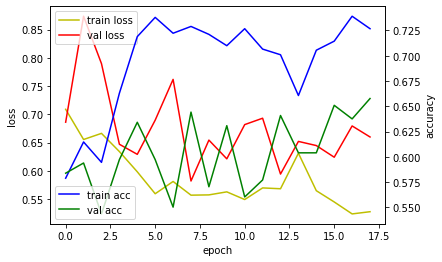

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Total Loss :  0.8328615427017212 
Total Accuracy :  0.6158940196037292


In [ ]:

# ImageDataGenerator로 받은 이미지를 학습하는 부분
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = ModelCheckpoint('multiclass_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 897 // 4,  # 전체 train 이미지 사이즈를 정해둔 batch 사이즈로 나눠줍니다.
    validation_data = valid_generator,
    epochs = 50,
    callbacks=[early_stopping, checkpoint_callback]
)
fig, loss_acc = plt.subplots()
acc = loss_acc.twinx()

loss_acc.plot(history.history['loss'], 'y', label='train loss')
loss_acc.plot(history.history['val_loss'], 'r', label='val loss')
loss_acc.set_xlabel('epoch')
loss_acc.set_ylabel('loss')
loss_acc.legend(loc='upper left')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.plot(history.history['val_accuracy'], 'g', label='val acc')
acc.set_ylabel('accuracy')
acc.legend(loc='lower left')

plt.show()

scores = model.evaluate_generator(generator=test_generator)
print("Total Loss : ", scores[0], "\nTotal Accuracy : ", scores[1])

epoch 4

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
224/224 [==============================] - ETA: 0s - loss: 0.6893 - accuracy: 0.5588

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


224/224 [==============================] - 80s 355ms/step - loss: 0.6893 - accuracy: 0.5588 - val_loss: 0.6819 - val_accuracy: 0.5839

Epoch 00001: val_loss improved from inf to 0.68190, saving model to multiclass_weights.h5
Epoch 2/50
224/224 [==============================] - 79s 352ms/step - loss: 0.6684 - accuracy: 0.5801 - val_loss: 0.6772 - val_accuracy: 0.5839

Epoch 00002: val_loss improved from 0.68190 to 0.67723, saving model to multiclass_weights.h5
Epoch 3/50
224/224 [==============================] - 80s 355ms/step - loss: 0.6838 - accuracy: 0.5722 - val_loss: 0.6851 - val_accuracy: 0.5839

Epoch 00003: val_loss did not improve from 0.67723
Epoch 4/50
224/224 [==============================] - 79s 352ms/step - loss: 0.6756 - accuracy: 0.5823 - val_loss: 0.6680 - val_accuracy: 0.5839

Epoch 00004: val_loss improved from 0.67723 to 0.66796, saving model to multiclass_weights.h5
Epoch 5/50
224/224 [==============================] - 80s 356ms/step - loss: 0.6984 - accuracy: 0.

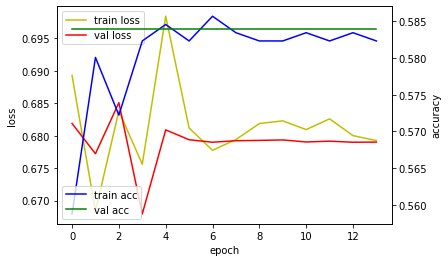

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Total Loss :  0.6794155836105347 
Total Accuracy :  0.5827814340591431


In [ ]:

# ImageDataGenerator로 받은 이미지를 학습하는 부분
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = ModelCheckpoint('multiclass_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 897 // 4,  # 전체 train 이미지 사이즈를 정해둔 batch 사이즈로 나눠줍니다.
    validation_data = valid_generator,
    epochs = 50,
    callbacks=[early_stopping, checkpoint_callback]
)
fig, loss_acc = plt.subplots()
acc = loss_acc.twinx()

loss_acc.plot(history.history['loss'], 'y', label='train loss')
loss_acc.plot(history.history['val_loss'], 'r', label='val loss')
loss_acc.set_xlabel('epoch')
loss_acc.set_ylabel('loss')
loss_acc.legend(loc='upper left')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.plot(history.history['val_accuracy'], 'g', label='val acc')
acc.set_ylabel('accuracy')
acc.legend(loc='lower left')

plt.show()

scores = model.evaluate_generator(generator=test_generator)
print("Total Loss : ", scores[0], "\nTotal Accuracy : ", scores[1])

epoch : 1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
642/642 [==============================] - 56s 87ms/step - loss: 0.7149 - accuracy: 0.5421 - val_loss: 0.6577 - val_accuracy: 0.5435

Epoch 00001: val_loss improved from inf to 0.65768, saving model to multiclass_weights.h5
Epoch 2/50
642/642 [==============================] - 56s 87ms/step - loss: 0.6848 - accuracy: 0.5467 - val_loss: 0.6413 - val_accuracy: 0.5435

Epoch 00002: val_loss improved from 0.65768 to 0.64131, saving model to multiclass_weights.h5
Epoch 3/50
642/642 [==============================] - 56s 87ms/step - loss: 0.6848 - accuracy: 0.5249 - val_loss: 0.6371 - val_accuracy: 0.5435

Epoch 00003: val_loss improved from 0.64131 to 0.63705, saving model to multiclass_weights.h5
Epoch 4/50
642/642 [==============================] - 55s 86ms/step - loss: 0.6752 - accuracy: 0.5405 - val_loss: 0.6409 - val_accuracy: 0.5435

Epoch 00004: val_loss did not improve from 0.63705
Epoch 5/50
642/642 [==============================] - 54s 84ms/step - loss: 0.6931 - accura

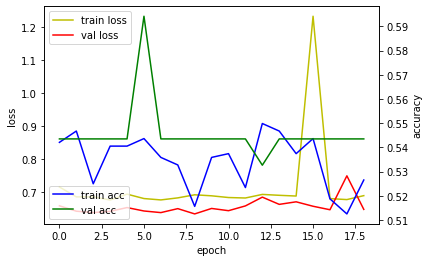

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Total Loss :  0.6468068361282349 
Total Accuracy :  0.54347825050354


In [ ]:

# ImageDataGenerator로 받은 이미지를 학습하는 부분
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = ModelCheckpoint('multiclass_weights.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = 642 // 1,  # 전체 train 이미지 사이즈를 정해둔 batch 사이즈로 나눠줍니다.
    validation_data = valid_generator,
    epochs = 50,
    callbacks=[early_stopping, checkpoint_callback]
)
fig, loss_acc = plt.subplots()
acc = loss_acc.twinx()

loss_acc.plot(history.history['loss'], 'y', label='train loss')
loss_acc.plot(history.history['val_loss'], 'r', label='val loss')
loss_acc.set_xlabel('epoch')
loss_acc.set_ylabel('loss')
loss_acc.legend(loc='upper left')

acc.plot(history.history['accuracy'], 'b', label='train acc')
acc.plot(history.history['val_accuracy'], 'g', label='val acc')
acc.set_ylabel('accuracy')
acc.legend(loc='lower left')

plt.show()

scores = model.evaluate_generator(generator=test_generator)
print("Total Loss : ", scores[0], "\nTotal Accuracy : ", scores[1])

In [ ]:
##test_generator 리셋
test_generator.reset()

#output = model.predict_generator(test_generator)
print("test_generator 종류:",test_generator.class_indices)
x_test,y_test=test_generator.next()
class_map = {
    0: 'just_face',
    1: 'with_mask', 
}
for x, y in test_generator:
    print(x.shape, y.shape)
    print(y[0].shape)
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        #axes[i//5, i%5].set_title(class_map[int(y[i])], fontsize=15)
        axes[i//5, i%5].axis('off')
    plt.show()
    break
    

print(y_test[1])
print((x_test[1].shape))
plt.imshow(x_test[1])
plt.show()
print(test_generator)
# for i in range(10):
#   test=np.argmax(test_generator[0][1][i])
#   predict=np.argmax(output[i])
#   print("real value:",class_list[test])
#   print("predict:",class_list[predict])
#   batch=test_generator.next()
#   plt.figure(figsize=(3,3))
#   plt.imshow(batch[0][i])
#   plt.show()  
#   scores = model.evaluate_generator(generator=test_generator)
# print("Total Loss : ", scores[0], "\nTotal Accuracy : ", scores[1])

test_generator 종류: {'just_face': 0, 'with_mask': 1}


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


(64, 512, 512, 3) (64, 2)


ValueError: ignored

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


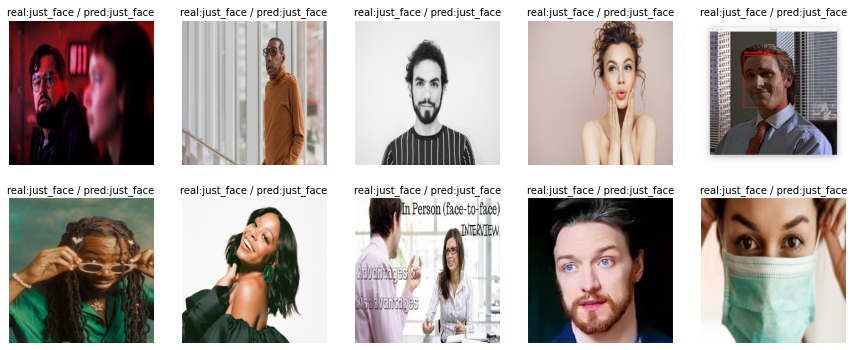

In [20]:
test_generator.reset()
output = model.predict_generator(test_generator)

test_generator.reset()
for x, y in test_generator:

  fig, axes = plt.subplots(2, 5)
  fig.set_size_inches(15, 6)
  for i in range(10):
      test=np.argmax(test_generator[0][1][i])
      predict=np.argmax(output[i])
      axes[i//5, i%5].imshow(x[i])
      axes[i//5, i%5].set_title("real:"+class_list[test]+" / "+"pred:"+class_list[predict], fontsize=10)
      axes[i//5, i%5].axis('off')
  plt.show()
  break